**Andy Tzanidakis**





Goals
--- 
In this notebook we aim to crossmatch Gaia DR3 + ZTF to select main-sequence FG dwarfs using the astrometric solutions provided by Gaia. In this notebook we will be covering the following workflows:


- Load and crossmatching ZTF and Gaia
- Peform a simple cone search on small areas
- Apply *custom* functions to ZTF light curves and applying querying conditions

In [262]:
import pyarrow as pa

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')


import lsdb
from lsdb import lsdb_client
client = lsdb_client(dask_on_ray=False, num_workers=8)

In [120]:
#Load ZTF, Gaia, and ZTF sources hipscats
gaia = lsdb.read_hipscat("/data3/epyc/projects3/ivoa_demo/gaia/catalog")
ztf = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

#sources load takes a minute, since it creates a healpix alignment on load
ztf_sources = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

## Cone search with LSDB



Here is a table from Pecaut & Mamajeck (2013) for the FG main-sequence star selections: 

| Spectral Type | Temperature | log(g) | BP_RP |
|---------------|-------------|--------|-------|
| F0V           | 7220        | 3.859  | 0.295 |
| F9.5V         | 5990        | 3.777  | 0.580 |
| G0V           | 5930        | 3.773  | 0.595 |
| G9V           | 5380        | 3.768  | 0.950 |

In [121]:
%%time
ra, dec = 30, 5
rad = 3 # in degrees
_sample = gaia.cone_search(
    ra=ra,
    dec=dec,
    radius=rad,
).crossmatch(
    ztf
).query(
    "nobs_g_ztf_dr14 > 100 and nobs_r_ztf_dr14 > 100 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5"
).compute()

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations


CPU times: user 3.32 s, sys: 1.07 s, total: 4.39 s
Wall time: 9.07 s


In [123]:
len(_sample) # number of sources in cone search

720

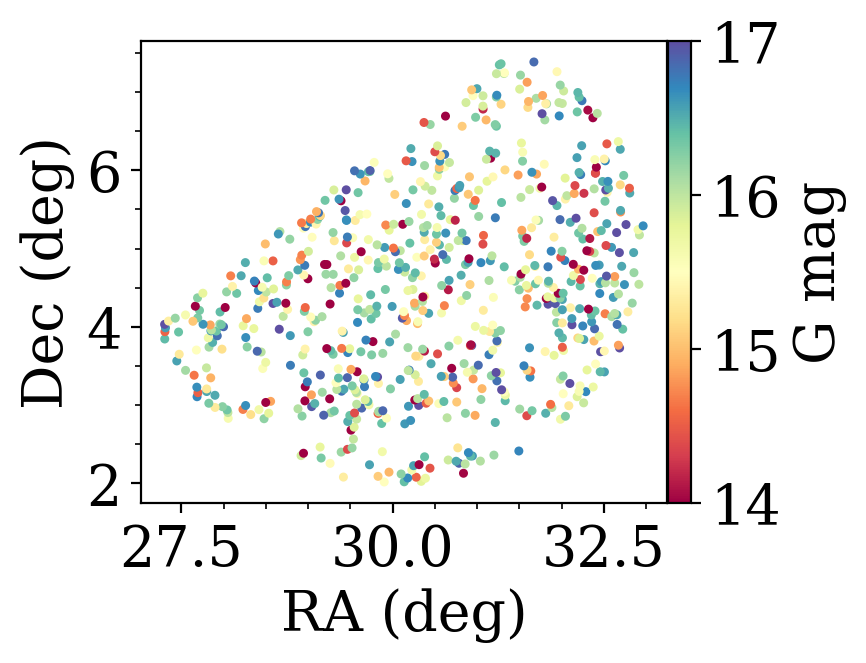

In [122]:
plt.figure(figsize=(4, 3))
plt.scatter(_sample["ra_gaia"],
 _sample["dec_gaia"],
  s=5, c=_sample["phot_g_mean_mag_gaia"], vmin=14, vmax=17, cmap='Spectral')
plt.colorbar(label="G mag", pad=0.001)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.minorticks_on()

In [129]:
# catalog object
_sample_hips = lsdb.from_dataframe(
    _sample, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

# join tables to final ZTF source list (i.e photometry)
_sample_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid"
).compute()

# don't compute table...
ss = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid"
)

In [132]:
# lazy final table
ss

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,parallax_error_gaia,parallax_over_error_gaia,pm_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,pmdec_error_gaia,ra_dec_corr_gaia,ra_parallax_corr_gaia,ra_pmra_corr_gaia,ra_pmdec_corr_gaia,dec_parallax_corr_gaia,dec_pmra_corr_gaia,dec_pmdec_corr_gaia,parallax_pmra_corr_gaia,parallax_pmdec_corr_gaia,pmra_pmdec_corr_gaia,astrometric_n_obs_al_gaia,astrometric_n_obs_ac_gaia,astrometric_n_good_obs_al_gaia,astrometric_n_bad_obs_al_gaia,astrometric_gof_al_gaia,astrometric_chi2_al_gaia,astrometric_excess_noise_gaia,astrometric_excess_noise_sig_gaia,astrometric_params_solved_gaia,astrometric_primary_flag_gaia,nu_eff_used_in_astrometry_gaia,pseudocolour_gaia,pseudocolour_error_gaia,ra_pseudocolour_corr_gaia,dec_pseudocolour_corr_gaia,parallax_pseudocolour_corr_gaia,pmra_pseudocolour_corr_gaia,pmdec_pseudocolour_corr_gaia,astrometric_matched_transits_gaia,visibility_periods_used_gaia,astrometric_sigma5d_max_gaia,matched_transits_gaia,new_matched_transits_gaia,matched_transits_removed_gaia,ipd_gof_harmonic_amplitude_gaia,ipd_gof_harmonic_phase_gaia,ipd_frac_multi_peak_gaia,ipd_frac_odd_win_gaia,ruwe_gaia,scan_direction_strength_k1_gaia,scan_direction_strength_k2_gaia,scan_direction_strength_k3_gaia,scan_direction_strength_k4_gaia,scan_direction_mean_k1_gaia,scan_direction_mean_k2_gaia,scan_direction_mean_k3_gaia,scan_direction_mean_k4_gaia,duplicated_source_gaia,phot_g_n_obs_gaia,phot_g_mean_flux_gaia,phot_g_mean_flux_error_gaia,phot_g_mean_flux_over_error_gaia,phot_g_mean_mag_gaia,phot_bp_n_obs_gaia,phot_bp_mean_flux_gaia,phot_bp_mean_flux_error_gaia,phot_bp_mean_flux_over_error_gaia,phot_bp_mean_mag_gaia,phot_rp_n_obs_gaia,phot_rp_mean_flux_gaia,phot_rp_mean_flux_error_gaia,phot_rp_mean_flux_over_error_gaia,phot_rp_mean_mag_gaia,phot_bp_rp_excess_factor_gaia,phot_bp_n_contaminated_transits_gaia,phot_bp_n_blended_transits_gaia,phot_rp_n_contaminated_transits_gaia,phot_rp_n_blended_transits_gaia,phot_proc_mode_gaia,bp_rp_gaia,bp_g_gaia,g_rp_gaia,radial_velocity_gaia,radial_velocity_error_gaia,rv_method_used_gaia,rv_nb_transits_gaia,rv_nb_deblended_transits_gaia,rv_visibility_periods_used_gaia,rv_expected_sig_to_noise_gaia,rv_renormalised_gof_gaia,rv_chisq_pvalue_gaia,rv_time_duration_gaia,rv_amplitude_robust_gaia,rv_template_teff_gaia,rv_template_logg_gaia,rv_template_fe_h_gaia,rv_atm_param_origin_gaia,vbroad_gaia,vbroad_error_gaia,vbroad_nb_transits_gaia,grvs_mag_gaia,grvs_mag_error_gaia,grvs_mag_nb_transits_gaia,rvs_spec_sig_to_noise_gaia,phot_variable_flag_gaia,l_gaia,b_gaia,ecl_lon_gaia,ecl_lat_gaia,in_qso_candidates_gaia,in_galaxy_candidates_gaia,non_single_star_gaia,has_xp_continuous_gaia,has_xp_sampled_gaia,has_rvs_gaia,has_epoch_photometry_gaia,has_epoch_rv_gaia,has_mcmc_gspphot_gaia,has_mcmc_msc_gaia,in_andromeda_survey_gaia,classprob_dsc_combmod_quasar_gaia,classprob_dsc_combmod_galaxy_gaia,classprob_dsc_combmod_star_gaia,teff_gspphot_gaia,teff_gspphot_lower_gaia,teff_gspphot_upper_gaia,logg_gspphot_gaia,logg_gspphot_lower_gaia,logg_gspphot_upper_gaia,mh_gspphot_gaia,mh_gspphot_lower_gaia,mh_gspphot_upper_gaia,distance_gspphot_gaia,distance_gspphot_lower_gaia,distance_gspphot_upper_gaia,azero_gspphot_gaia,azero_gspphot_lower_gaia,azero_gspphot_upper_gaia,ag_gspphot_gaia,ag_gspphot_lower_gaia,ag_gspphot_upper_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,libname_gspphot_gaia,Norder_gaia,Npix_gaia,Dir_gaia,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,index,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
npa

In [126]:
# computed final table
_sample_sources.head(1)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5016982922301800448,1636148068921376768,Gaia DR3 2508491562083228928,2508491562083228928,1456963486,2016.0,30.838011,0.019369,2.127205,0.014467,1.937337,...,0,451,13.97559,0.012795,59254.15077,12,r,6,10000,17823


In [201]:
# number of rgi detections
len(_sample_sources[_sample_sources.band=='r']), len(_sample_sources[_sample_sources.band=='g']), len(_sample_sources[_sample_sources.band=='i'])

(399007, 271185, 23417)

In [199]:
len(_sample_sources) # total

693609

In [133]:
len(_sample_sources), _sample_sources.keys() # contains ZTF photometry + Gaia astrometry

(693609,
 Index(['solution_id_gaia', 'designation_gaia', 'source_id_gaia',
        'random_index_gaia', 'ref_epoch_gaia', 'ra_gaia', 'ra_error_gaia',
        'dec_gaia', 'dec_error_gaia', 'parallax_gaia',
        ...
        'catflags', 'fieldID', 'mag', 'magerr', 'mjd', 'rcID', 'band', 'Norder',
        'Dir', 'Npix'],
       dtype='object', length=194))

In [134]:
print (f"Number of unique ZTF sources: {len(np.unique(_sample_sources.index))}")

Number of unique ZTF sources: 718


In [135]:
def fetch_lc(hips_id, table=_sample_sources, band='r'):
    """This function fetches the light curve for a given hips_id and band.
    
    Parameters
    ----------
    hips_id : int
    band (str): photometric band (default='r')

    Returns
    -------
    light curve table for a given band 
    """
    one_object = table.query(f"_hipscat_index == {hips_id}")

    if band=='r':
        one_object_rband = one_object.query("band == \"r\"")
        cat = one_object_rband['catflags'] != -32768 
        return one_object_rband["mjd"][cat], one_object_rband["mag"][cat], one_object_rband["magerr"][cat]

    elif band=='g':
        one_object_gband = one_object.query("band == \"g\"")
        cat = one_object_gband['catflags'] != -32768 
        return one_object_gband["mjd"][cat], one_object_gband["mag"][cat], one_object_gband["magerr"][cat]

    elif band=='i':
        one_object_iband = one_object.query("band == \"i\"")
        return one_object_iband["mjd"], one_object_iband["mag"], one_object_iband["magerr"]

    elif band=='all':
        one_object_rband = one_object.query("band == \"r\"")
        one_object_gband = one_object.query("band == \"g\"")
        one_object_iband = one_object.query("band == \"i\"")

        gband_mjd, gband_mag, gband_magerr = one_object_gband["mjd"], one_object_gband["mag"], one_object_gband["magerr"]
        rband_mjd, rband_mag, rband_magerr = one_object_rband["mjd"], one_object_rband["mag"], one_object_rband["magerr"]
        iband_mjd, iband_mag, iband_magerr = one_object_iband["mjd"], one_object_iband["mag"], one_object_iband["magerr"]


        return gband_mjd, gband_mag, gband_magerr, rband_mjd, rband_mag, rband_magerr, iband_mjd, iband_mag, iband_magerr

## Plotting and Exploring Individual Light Curves

In [138]:
%%time
# random sourceID
rnd = 5023602738215256064
lc_r = fetch_lc(rnd, band='r')
lc_g = fetch_lc(rnd, band='g')

CPU times: user 151 ms, sys: 71.1 ms, total: 222 ms
Wall time: 162 ms


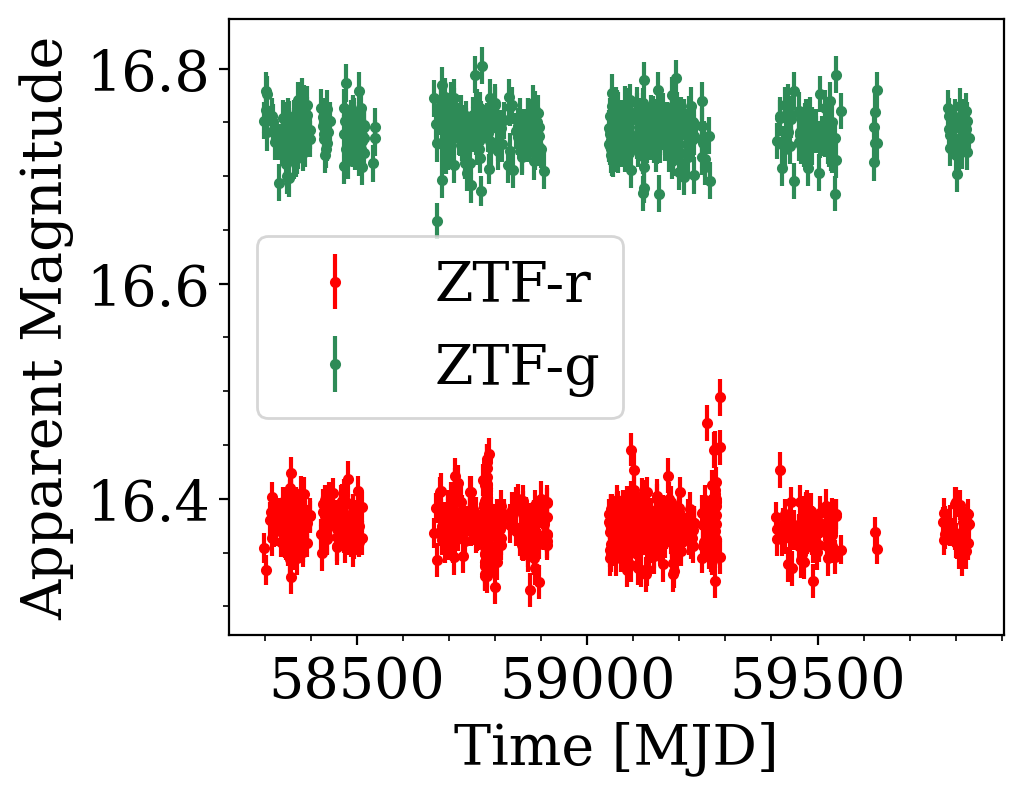

In [140]:
plt.figure(figsize=(5, 4))
plt.errorbar(lc_r[0], lc_r[1], yerr=lc_r[2], fmt='.', color='r', label='ZTF-r')
plt.errorbar(*lc_g, fmt='.', color='seagreen', label='ZTF-g')
plt.ylabel("Apparent Magnitude")
plt.xlabel("Time [MJD]")
plt.minorticks_on()
plt.legend()

## Custom Light Curve Querying

Suppose you would like to compute time-series features on each ZTF light curve object.

This feature is supported via the LSDB, `for_each` function by also specifying the photometric bandpass.

I would like my function to calculate the biweight location and scale of each light curve and return it as a Pandas DataFrame

In [141]:
from astropy.stats import biweight_location, biweight_scale

# let's try writing a custom function
def custom_function(df):
    """WIP: add option for other bandpasses..."""
    df_rband = df.query("band == \"r\"")
    cat = df_rband['catflags'] != -32768 # remove spurious measurements
    x, y, yerr = df_rband["mjd"][cat], df_rband["mag"][cat], df_rband["magerr"][cat]

    return pd.DataFrame(
        {
            "ps1_objid" : [df["ps1_objid"].values.tolist()[0]],
            "biw_loc": [biweight_location(y)], #compute std of the light curve
            "biw_scale": [biweight_scale(y)] #compute std of the light curve
        }
    )

In [142]:
ztf_sample_with_sources_rehips = lsdb.from_dataframe(
    _sample_sources, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia",
    threshold=1_000_000
)

In [143]:
%%time
# compute custom function for each light curve
var_analysis = ztf_sample_with_sources_rehips.for_each(
    key="ps1_objid",                       # groupby index
    ufunc=custom_function, # apply(ufunc) for each group
    meta={"ps1_objid": "i8", 
          "biw_loc": "f8", 
          "biw_scale": "f8"}                       # return metadata
).compute()

CPU times: user 2.02 s, sys: 3.1 s, total: 5.12 s
Wall time: 6.55 s


In [144]:
%%time 
lc_r = fetch_lc(rnd, band='r')
_ = biweight_location(lc_r[1])
_ = biweight_scale(lc_r[1])

CPU times: user 55.4 ms, sys: 27.7 ms, total: 83.1 ms
Wall time: 69.3 ms


Text(0.5, 0, '$\\mu$ [loc]')

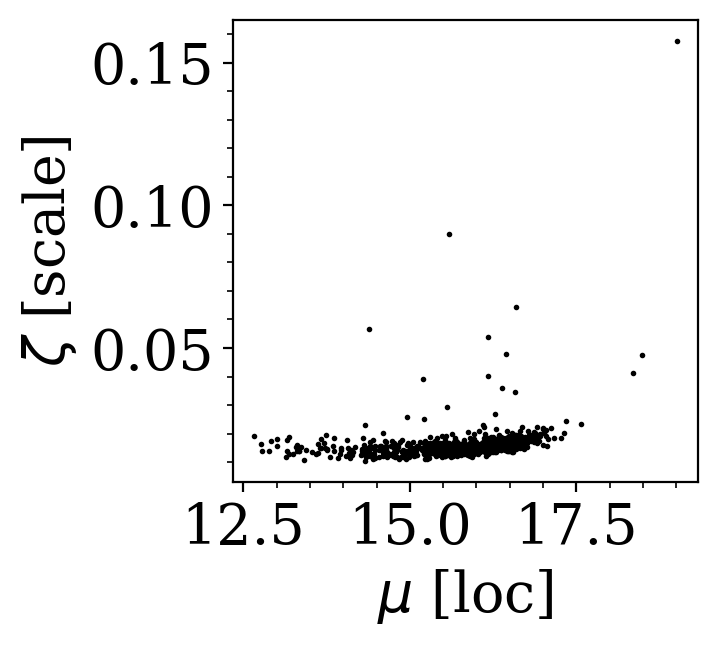

In [146]:
plt.figure(figsize=(3,3))
plt.scatter(var_analysis["biw_loc"], var_analysis["biw_scale"], s=1, color='k')
plt.minorticks_on()

plt.ylabel("$\zeta$ [scale]")
plt.xlabel("$\mu$ [loc]")

## Custom Light Curve Querying Dask

One of the large challenges faced above is that we need to compute our final table before we can run `for_each` which would take a very long time for large samples.




- Say we want to do the following procedure **without** directly computing the soure table. Can it handle this in dask?


** Currently facing some issues with the LSDB API **

## Try with TAPE

In [232]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

In [233]:
client.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42663/status,
Dashboard: http://127.0.0.1:42663/status,Workers: 8
Total threads: 8,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41436,Workers: 8
Dashboard: http://127.0.0.1:42663/status,Total threads: 8
Started: 24 minutes ago,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:39957,Total threads: 1
Dashboard: http://127.0.0.1:38273/status,Memory: 125.95 GiB
Nanny: tcp://127.0.0.1:40511,


In [234]:
# Initialize an Ensemble
ens = Ensemble(client=client.client)
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42663/status,
Dashboard: http://127.0.0.1:42663/status,Workers: 8
Total threads: 8,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41436,Workers: 8
Dashboard: http://127.0.0.1:42663/status,Total threads: 8
Started: 24 minutes ago,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:39957,Total threads: 1
Dashboard: http://127.0.0.1:38273/status,Memory: 125.95 GiB
Nanny: tcp://127.0.0.1:40511,


In [235]:
ens.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42663/status,
Dashboard: http://127.0.0.1:42663/status,Workers: 8
Total threads: 8,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41436,Workers: 8
Dashboard: http://127.0.0.1:42663/status,Total threads: 8
Started: 24 minutes ago,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:39957,Total threads: 1
Dashboard: http://127.0.0.1:38273/status,Memory: 125.95 GiB
Nanny: tcp://127.0.0.1:40511,


In [236]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='mag_err',
        band_col='band',
      )

In [237]:
# We can read from parquet
ens.from_dask_dataframe(
    source_frame=ss._ddf.reset_index(),
    object_frame=_sample_hips._ddf.reset_index(),
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

In [238]:
ens._source.head(1) # full source table

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5016982922301800448,1636148068921376768,Gaia DR3 2508491562083228928,2508491562083228928,1456963486,2016.0,30.838011,0.019369,2.127205,0.014467,1.937337,...,0,451,13.97559,0.012795,59254.15077,12,r,6,10000,17823


In [239]:
ens._object.head(1) # full object table

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5016982922301800448,1636148068921376768,Gaia DR3 2508491562083228928,2508491562083228928,1456963486,2016.0,30.838011,0.019369,2.127205,0.014467,1.937337,...,408,580,30,14.502589,13.957728,13.806696,3,0,278,0.000025


In [240]:
def calc_biweight_lc(mag, flag):
    """custom function"""
    rmv = flag != -32768
    return biweight_location(mag[rmv]), biweight_scale(mag[rmv])

In [241]:
# Define DataFrame with loc and scale
my_meta = pd.DataFrame(columns=['loc', 'scale'],
                       dtype=float, 
                       index=pd.Series(name="_hipscat_index", dtype=str))

In [242]:
# select only r-band light curves
ens.query("band=='r'", table="source") 

In [246]:
# this should return an empty table
ens._source.compute()[ens._source.compute().band=='g']

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,


In [247]:
# apply calc_biweight function
calc_ = ens.batch(
    calc_biweight_lc,
    'mag', 'catflags',
    use_map=True, 
    compute=False
)

In [248]:
# not working...
#pd.DataFrame(columns=['loc', 'scale'], index=calc_.index) # ??

In [249]:
def make_df(df):
    """Map resulsts as a pd.DataFrame"""
    result_df = pd.DataFrame(columns=['loc', 'scale'], index=df.index)
    for i, val in df.items():
        result_df.loc[i] = val
    return result_df

In [250]:
%%time 
result = make_df(calc_.compute())

CPU times: user 3.23 s, sys: 1.02 s, total: 4.26 s
Wall time: 8.35 s


In [251]:
result.head(1)

,loc,scale
_hipscat_index,,
5016982922301800448,13.956546,0.012882


In [252]:
# assign to object table
ens.assign(table='object', loc=result["loc"], scale=result["scale"])

In [253]:
ens_obj_comp = ens._object.compute() # let's compute object table and see what's inside

In [255]:
ens_obj_comp.head(1) # nice we can see loc and scale have been mappped!

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,loc,scale
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5016982922301800448,1636148068921376768,Gaia DR3 2508491562083228928,2508491562083228928,1456963486,2016.0,30.838011,0.019369,2.127205,0.014467,1.937337,...,30,14.502589,13.957728,13.806696,3,0,278,0.000025,13.956545806039312,0.012882090978859905


In [256]:
ens_src_comp = ens._source.compute() # let's compute object table and see what's inside

In [260]:
ens_src_comp.head(1)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5016982922301800448,1636148068921376768,Gaia DR3 2508491562083228928,2508491562083228928,1456963486,2016.0,30.838011,0.019369,2.127205,0.014467,1.937337,...,0,451,13.97559,0.012795,59254.15077,12,r,6,10000,17823


In [264]:
# now we want to re-join `result` table to our original source table... 

In [268]:
result.index.values # index values can be 

array([5016982922301800448, 5017000351279087616, 5017003997706321920,
       5017004504512462848, 5017008507421982720, 5017009259041259520,
       5022777632048021504, 5022874054063816704, 5022892453703712768,
       5022941124273111040, 5022941699798728704, 5022949765747310592,
       5022954868168458240, 5022957183155830784, 5022961787360772096,
       5022962826742857728, 5022967899099234304, 5022976020882391040,
       5022977356617220096, 5022979796158644224, 5023000034044542976,
       5023009388483313664, 5023014198846685184, 5023022264795267072,
       5023028960649281536, 5023072520207597568, 5023114628066967552,
       5023175560767995904, 5023188505799426048, 5023280349380083712,
       5023287998716837888, 5023297859961749504, 5023298585811222528,
       5023317608221376512, 5023318192336928768, 5023327782998900736,
       5023472647950827521, 5023484459110891520, 5023496532263960576,
       5023524088774131712, 5023535779675111424, 5023542664507686912,
       5023544498458

In [289]:
# compute my object table from the beginning
obj_final = _sample_hips.compute()

# _sample_sources final source list...

In [292]:
obj_final_mod = obj_final.join(result, how='outer')

In [341]:
_w = (obj_final_mod['loc']>18) & (obj_final_mod['scale']<0.1)

In [343]:
_sample_sources[_w].head(10) # yay! 

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5024954553401868288,1636148068921376768,Gaia DR3 2512477257374168448,2512477257374168448,579435770,2016.0,28.055041,0.034035,2.828777,0.027713,0.609694,...,0,450,19.748659,0.122038,59090.39073,23,g,6,10000,17852
5024954553401868288,1636148068921376768,Gaia DR3 2512477257374168448,2512477257374168448,579435770,2016.0,28.055041,0.034035,2.828777,0.027713,0.609694,...,0,450,17.668640,0.031264,58374.30195,23,i,6,10000,17852
5024954553401868288,1636148068921376768,Gaia DR3 2512477257374168448,2512477257374168448,579435770,2016.0,28.055041,0.034035,2.828777,0.027713,0.609694,...,0,450,17.671461,0.031325,58370.32300,23,i,6,10000,17852
5024954553401868288,1636148068921376768,Gaia DR3 2512477257374168448,2512477257374168448,579435770,2016.0,28.055041,0.034035,2.828777,0.027713,0.609694,...,0,450,17.685551,0.031628,58366.29816,23,i,6,10000,17852
5024954553401868288,1636148068921376768,Gaia DR3 2512477257374168448,2512477257374168448,579435770,2016.0,28.055041,0.034035,2.828777,0.027713,0.609694,...,-32768,450,19.999529,0.141250,59828.48340,23,g,6,10000,17852
5024954553401868288,1636148068921376768,Gaia DR3 2512477257374168448,2512477257374168448,579435770,2016.0,28.055041,0.034035,2.828777,0.027713,0.609694,...,0,450,17.664680,0.031180,58351.34233,23,i,6,10000,17852
5024954553401868288,1636148068921376768,Gaia DR3 2512477257374168448,2512477257374168448,579435770,2016.0,28.055041,0.034035,2.828777,0.027713,0.609694,...,0,450,17.688166,0.031685,58347.39534,23,i,6,10000,17852
5024954553401868288,1636148068921376768,Gaia DR3 2512477257374168448,2512477257374168448,579435770,2016.0,28.055041,0.034035,2.828777,0.027713,0.609694,...,0,450,17.632683,0.030510,58342.39560,23,i,6,10000,17852
5024954553401868288,1636148068921376768,Gaia DR3 2512477257374168448,2512477257374168448,579435770,2016.0,28.055041,0.034035,2.828777,0.027713,0.609694,...,0,450,18.443739,0.052286,59095.45547,23,r,6,10000,17852


In [ ]:
# problem now is that gi and 

In [100]:
pa_table = pa.Table.from_pandas(result)
pa_table

pyarrow.Table
loc: double
scale: double
_hipscat_index: uint64
----
loc: [[15.523114775698655,14.837025585533357,16.51325529817447,14.999427491000192,14.61422889331569,...,16.295616402854197,15.366704609572711,15.95539064863925,15.421996313229542,14.890390084803782]]
scale: [[0.01363180575304406,0.011172539013265769,0.017714400688583685,0.012746954560856094,0.015064475940839542,...,0.015600189957259702,0.013819339689059325,0.01440924212320005,0.01250302718034247,0.014215517321890372]]
_hipscat_index: [[5035858397329620992,5035862275685089280,5036051202706505728,5036054715989753856,5036062893607485440,...,5039017697963147264,5039024844788727808,5039119020536627200,5039133022130012160,5039140327869382656]]

In [101]:
pa.parquet.write_table(pa_table, f"fg_test_file.parquet")

In [104]:
ye = pd.read_parquet("fg_test_file.parquet", engine='pyarrow')

In [113]:
ye

,loc,scale
_hipscat_index,,
5035858397329620992,15.523115,0.013632
5035862275685089280,14.837026,0.011173
5036051202706505728,16.513255,0.017714
5036054715989753856,14.999427,0.012747
5036062893607485440,14.614229,0.015064
...,...,...
5039017697963147264,16.295616,0.015600
5039024844788727808,15.366705,0.013819
5039119020536627200,15.955391,0.014409
